In [56]:
# 今回はlightGBMではなく重回帰分析を用いる
import math
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [57]:
df1 = pd.read_csv("../movie/tmdb_5000_movies.csv")
df2 = pd.read_csv("../movie/tmdb_5000_credits.csv")
df3 = pd.merge(df1,df2,on="title")
df3.head()
#いらない場所を落とす
df3 = df3.drop(columns=['homepage', 'id',"original_title","overview","status","tagline","vote_count","movie_id","popularity","original_language","title","production_countries","keywords","cast"])

# 重回帰分析のため欠損値は処理
# 今回は完全のdrop
df3 = df3.dropna(axis=0,how="any")

# 収入が0のものを削除
df3 = df3.query("revenue >= 1000")
df3 = df3.dropna().reset_index(drop=True)
df3.shape

(3357, 9)

In [58]:
# 今回は監督を使いたいと思っているので、まずは映画の監督を抽出
crews = df3["crew"]
crews_list = list()
num = 0
for each_crews in crews:
    num += 1
    if each_crews == "[]":
        crews_list.append("")
    else:
        each_crews = ast.literal_eval(each_crews[1:-1])
        producer_list = list()
        for each_crew in each_crews:
            try:
                if each_crew["job"] == "Director":
                    crew = each_crew["name"]
                    producer_list.append(crew)
            except:
                crew = each_crews["name"]
                producer_list.append(crew)
        crews_list.append(producer_list)

#  ダブってるのがあるからなんとかする(重複解消)
for i in range(len(crews_list)):
    crews_list[i] = list(set(crews_list[i]))

# それをもとにどれだけ出てきたかをカウント
crews_dict = dict()
for crews in crews_list:
    for director in crews:
        if director in crews_dict:
            crews_dict[director] += 1
        else:
            crews_dict[director] = 1

# さっき作った映画の辞書をもとに収入を入れていく
df4 = df3.filter(["revenue","crew"])
df4["director_sales"] = 0

# とりあえず辞書を作ってそこに格納
# ここに各々の監督の作品の数で売り上げを割って平均の売り上げを求める
# 配列の左が合計値,右が足した数
director_sales = crews_dict
for key in crews_dict:
    director_sales[key] = [0,0]

sales = df4["revenue"]
for i in range(len(sales)):
    per_sales = sales.iloc[i]
    director = crews_list[i]
    for j in director:
        director_sales[j][0] += per_sales
        director_sales[j][1] += 1

# その後足した分だけ割っていく
new_director_sales = dict()
for key,value in director_sales.items():
    sum_sales = value[0]
    sum_num = value[1]
    new_director_sales[key] = sum_sales//sum_num

# 最後に特徴量を作成
director_sum_sales = list()
for directors in crews_list:
    num = 0
    for i in range(len(directors)):
        director = directors[i]
        num += new_director_sales[director]
    num = num//(i+1)
    director_sum_sales.append(num)

# 作成した特徴量をデータフレームに格納
df4["director_sales"] = director_sum_sales
df4 = df4.drop(columns=["revenue"])

# 最後に結合
df3 = pd.concat([df3, df4], axis=1,ignore_index=False)
df3 = df3.drop(columns=["crew"])
df3.head()

,budget,genres,production_companies,release_date,revenue,runtime,spoken_languages,vote_average,director_sales
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",7.2,840509919
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",6.9,453859051
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",6.3,387649829
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",7.6,528435404
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",6.1,527261338


In [59]:
# 制作会社も過去の売上から特徴量を作成
# 方法としては監督と同じにする
company_names = df3["production_companies"]
company_list = list()
num = 0
for self_company_names in company_names:
    num += 1
    if self_company_names == "[]":
        company_list.append("")
    else:
        self_company_names = ast.literal_eval(self_company_names[1:-1])
        company_name = list()
        for self_company_name in self_company_names:
            try:
                name = self_company_name["name"]
                company_name.append(name)
            except:
                name = self_company_names["name"]
                company_name.append(name)
            if len(company_name) >= 2:
                break
        company_list.append(company_name)

# 続いて辞書型を作成してその中に数を入れていく
company_name_dict = dict()  #会社の種類と出てくる回数を保持
revenue = df3["revenue"]
for i in range(len(company_list)):
    per_company_names = company_list[i]
    for company_name in per_company_names:
        if company_name in company_name_dict:
            company_name_dict[company_name][0] += 1
            company_name_dict[company_name][1] += revenue[i]
        else:
            company_name_dict[company_name] = [1, revenue[i]]

# 一回しか出てこないものは取り除く
company_dict = dict()
for key, value in company_name_dict.items():
    count_value = value[0]
    revenue_value = value[1]
    if count_value > 2:
        company_dict[key] = revenue_value // count_value

# とりあえずこれらの値を当てはめたデータフレームを作成する
company_sales = list([0] * len(company_list))
for i in range(len(company_list)):
    companies = company_list[i]
    for company in companies:
        try:
            company_sales[i] += company_dict[company]
        except:
            company_sales[i] = company_sales[i] * 2
    company_sales[i] = company_sales[i] // 2
for j in range(len(company_sales)):
    if company_sales[j] == 0:
        company_sales[j] = revenue[j]

# 最後に結合
df3["company_sales"] = company_sales
df3 = df3.drop(columns=["production_companies"])
df3.shape


(3357, 9)

In [60]:
# 話されている言語の数を特徴量として作成(話されている言語の種類を取得)
spoken_languages = df3["spoken_languages"]
language_list = list()
for spoken_language in spoken_languages:
    if spoken_language == "[]":
        language_list.append(1)
    else:
        spoken_language = ast.literal_eval(spoken_language[1:-1])
        language_type = len(spoken_language)
        language_list.append(language_type)

# 作成したものを代入
df3["spoken_languages"] = language_list
df3.head()

,budget,genres,release_date,revenue,runtime,spoken_languages,vote_average,director_sales,company_sales
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2009-12-10,2787965087,162.0,2,7.2,840509919,259081578
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",2007-05-19,961000000,169.0,2,6.9,453859051,317561395
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2015-10-26,880674609,148.0,5,6.3,387649829,160865676
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",2012-07-16,1084939099,165.0,2,7.6,528435404,234020167
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2012-03-07,284139100,132.0,2,6.1,527261338,255468697


In [61]:
# リリース日を月と年月に分けてそれぞれ代入
# また月日は円循環なので,sinとcosに分ける

# まずは月日を1/1からどれだけ経ったかに変換する関数を作成
def convert_date_to_number(month: int, day: int) -> int:
    # 1月1日からの経過日数を保持する変数
    elapsed_days = 0

    # 1月から現在の月までをループ
    for m in range(1, month):
        # 当該月の日数を加算
        elapsed_days += get_days_in_month(m)

    # 最後に現在日を加算
    elapsed_days += day

    return elapsed_days

def get_days_in_month(month: int) -> int:
    # 2月までは日数が固定
    if month in [1, 3, 5, 7, 8, 10, 12]:
        return 31
    elif month == 2:
        return 28
    else:
        return 30

# 次にsinとcosに変換する関数を作成
def encode(month, day):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    date_num = convert_date_to_number(month, day)
    sin = np.sin(2 * np.pi * date_num / 365)
    cos = np.cos(2 * np.pi * date_num / 365)
    return [sin,cos]

# 新しい特徴量を作成
df3["release_year"] = 0
df3["release_day_sin"] = 0
df3["release_day_cos"] = 0
release_year = dict()
release_day_sin = dict()
release_day_cos = dict()
for key in df3["release_date"]:
    if type(key) == str:
        year,month,day = key.split("-")
        release_year[key] = float(year)
        day = encode(int(month),int(day))
        day_sin,day_cos = day[0],day[1]
        release_day_sin[key] = day_sin
        release_day_cos[key] = day_cos

# では作ったものを入れていく
df3["release_year"] = df3["release_date"].replace(release_year).astype(float)
df3["release_day_cos"] = df3["release_date"].replace(release_day_cos).astype(float)
df3["release_day_sin"] = df3["release_date"].replace(release_day_sin).astype(float)
df3 = df3.drop(columns=["release_date"])
df3.head()

,budget,genres,revenue,runtime,spoken_languages,vote_average,director_sales,company_sales,release_year,release_day_sin,release_day_cos
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2787965087,162.0,2,7.2,840509919,259081578,2009.0,-0.353676,0.935368
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",961000000,169.0,2,6.9,453859051,317561395,2007.0,0.680773,-0.732494
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",880674609,148.0,5,6.3,387649829,160865676,2015.0,-0.907014,0.421101
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",1084939099,165.0,2,7.6,528435404,234020167,2012.0,-0.247022,-0.969010
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",284139100,132.0,2,6.1,527261338,255468697,2012.0,0.907014,0.421101


In [62]:
# ジャンルをワンホットエンコーディング
genres_list = ["Action","Adventure","Fantasy","Science Fiction","Crime","Drama","Thriller","Animation","Family","Western","Comedy","Romance","Horror","Mystery","History","War","Music","Documentary","Foreign"]

# とりあえず特徴量を作成
for genre in genres_list:
    df3[genre] = 0

genres = df3["genres"]
# とりあえず種類が欲しいので種類を確認
# まずは辞書を作成
movie_genre_dict = dict()
movie_genre_list = list()

for movie_genre in genres:
    if movie_genre == "[]":
        movie_genre_list.append("")
    else:
        per_genre_list = ast.literal_eval(movie_genre[1:-1])
        genre_list = []
        for per_genre in per_genre_list:
            if type(per_genre) == dict:
                movie_id = per_genre["id"]
                movie_name = per_genre["name"]
                movie_genre_dict[movie_id] = movie_name
                genre_list.append(movie_name)
            else:
                movie_id = per_genre_list["id"]
                movie_name = per_genre_list["name"]
                movie_genre_dict[movie_id] = movie_name
                genre_list.append(movie_name)
                break
        movie_genre_list.append(genre_list)
        genre_list = []

def put_genre(df,movie_genre_list):
    for i in range(len(df)):
        for genre in movie_genre_list[i]:
            df.at[i,genre] = 1.0
put_genre(df3,movie_genre_list)


# では代入開始
def put_genre(df,movie_genre_list):

    for i,row in df.iterrows():
        num = 0
        for genre in movie_genre_list[num]:
            df.at[i,genre] = 1.0
            num += 1
put_genre(df3,movie_genre_list)

# 最後に不必要な部分を落とす
df3 = df3.drop(columns=["genres"])

In [63]:
# 訓練データと検証データ,テストデータに分ける
train_val,test = train_test_split(df3,test_size=0.2,random_state=0)

In [64]:
# 散布図を表示
# colname = train_val.columns
# for name in colname:
#     train_val.plot(kind="scatter",x= name,y= "revenue")

In [65]:
# ハズレ値の処理
out_line = train_val[(train_val["revenue"] > 2.5*10**9)].index
train_val = train_val.drop([0],axis=0)

In [66]:
# 目的変数を設定
df3_y = df3[["revenue"]]
df3_x = df3.drop(columns=["revenue"])

In [67]:
# 学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(df3_x, df3_y, test_size=0.3, random_state=1)
X_train

,budget,runtime,spoken_languages,vote_average,director_sales,company_sales,release_year,release_day_sin,release_day_cos,Action,...,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign
2544,0,87.0,2,5.9,41457125,6861102,2011.0,0.661635,0.749826,1,...,0,1,0,0,0,0,0,0,0,0
2723,7000000,192.0,2,7.4,29385320,19217660,2004.0,-0.746972,0.664855,1,...,0,0,1,0,0,0,0,0,0,0
557,70000000,144.0,2,6.6,338792339,209749496,1991.0,-0.337523,0.941317,1,...,0,1,0,0,0,0,0,0,0,0
785,55000000,132.0,2,7.1,97501640,170865020,2014.0,-0.993257,-0.115935,1,...,0,0,0,0,0,0,0,0,0,0
1004,45000000,103.0,2,6.5,181645870,255468697,2011.0,-0.622047,0.782980,1,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,6000000,110.0,2,7.4,130962608,176521371,1969.0,-0.991114,-0.133015,1,...,1,0,0,0,0,1,0,0,0,0
905,50000000,140.0,2,6.8,94790926,125580133,1998.0,-0.455907,-0.890028,1,...,0,0,0,0,1,0,0,0,0,0
1096,40000000,129.0,2,6.2,77584735,122624939,2009.0,0.594727,0.803928,1,...,0,1,1,0,0,0,0,0,0,0
235,115000000,114.0,2,6.0,164602163,144820542,2016.0,0.996659,-0.081676,1,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# データの標準化
sc_model_x = StandardScaler()
sc_model_x.fit(X_train)

# 各列を標準化して格納
sc_x = sc_model_x.transform(X_train)

# 正解データも標準化
sc_model_y = StandardScaler()
sc_model_y.fit(y_train)
sc_y = sc_model_y.transform(y_train)

# 検証データを標準化
sc_x_val = sc_model_x.transform(X_test)
sc_y_val = sc_model_y.transform(y_test)

In [111]:
model = LinearRegression()
model.fit(sc_x,sc_y)
model.score(sc_x,sc_y)

0.6940768668608533

In [128]:
model.score(sc_x_val,sc_y_val)

0.6698303546504458

In [157]:
# 回帰の影響度を分析
tmp = pd.DataFrame(model.coef_)
tmp = tmp.transpose()
tmp.index = X_train.columns
tmp.columns = ["importance"]
tmp = tmp.abs()
#tmp.drop(genres_list)
tmp["importance"] = tmp["importance"].where(~tmp.index.isin(genres_list), 10**(-5))
tmp


,importance
budget,0.362455
runtime,0.052021
spoken_languages,0.029473
vote_average,0.104517
director_sales,0.443967
company_sales,0.102777
release_year,0.000707
release_day_sin,0.011437
release_day_cos,0.009131
Action,0.000010


In [158]:
tmp["feature"] = tmp.index
tmp.index = pd.RangeIndex(len(tmp))
tmp

,importance,feature
0,0.362455,budget
1,0.052021,runtime
2,0.029473,spoken_languages
3,0.104517,vote_average
4,0.443967,director_sales
5,0.102777,company_sales
6,0.000707,release_year
7,0.011437,release_day_sin
8,0.009131,release_day_cos
9,0.000010,Action


In [159]:
df_importance = tmp.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,importance,feature
4,0.443967,director_sales
0,0.362455,budget
3,0.104517,vote_average
5,0.102777,company_sales
1,0.052021,runtime
2,0.029473,spoken_languages
7,0.011437,release_day_sin
8,0.009131,release_day_cos
6,0.000707,release_year
22,0.000010,Mystery


In [164]:
# 特徴量重要度を棒グラフでプロットする関数
def plot_feature_importance(df):
    n_features = len(df)                              # 特徴量数(説明変数の個数)
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values             # 特徴量の取得
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

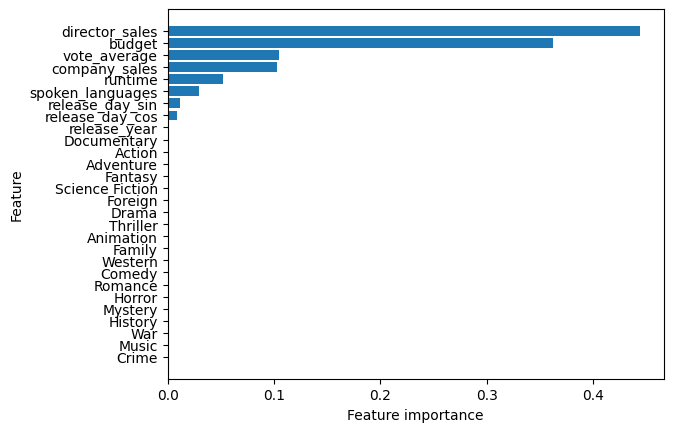

In [165]:
plot_feature_importance(tmp)